In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy as sp

%matplotlib inline

In [2]:
# класс one-hot encoder'а для MNIST
class OneHotEncoder:
    def __init__(self):
        self.transform_mapping = np.zeros((10,10))
        for i in range(self.transform_mapping.shape[0]):
            self.transform_mapping[i][i] = 1.0
    def transform(self, y):
        return self.transform_mapping[int(y)]

In [3]:
def make_submission(X_test, net, fname="my_submission.csv"):
    with open(fname,'w') as fout:
        fout.write('Id,Category')
        for i in range(X_test.shape[0]):
            y_h = net.forward(X_test[i])
            y = np.argmax(y_h)
            fout.write("\n{},{}".format(i, int(y)))

In [4]:
# внимание, тут Y_test в обычном формате(не onehot)
def compute_acc(X_test, Y_test, net):
    acc = 0.0
    for i in range(X_test.shape[0]):
        y_h = net.forward(X_test[i])
        y = np.argmax(y_h)
        if(y == Y_test[i]):
            acc += 1.0
    return acc / Y_test.shape[0]

In [42]:
train_data = None
test_data = None
encoder = OneHotEncoder()

with open('data_train.pickle', 'rb') as fin:
    train_data = pickle.load(fin)
with open('data_test_no_labels.pickle', 'rb') as fin:
    test_data = pickle.load(fin)
    
X_marked = train_data['data']
Y_marked = train_data['target']
Y_marked_oh = np.array([encoder.transform(y) for y in Y_marked])

X_not_marked = test_data['data']

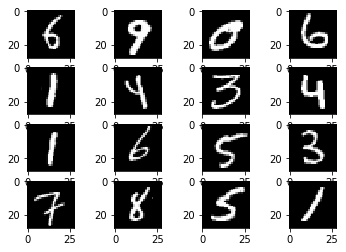

In [23]:
n = 4
for i in range(n*n):
    plt.subplot(n, n, i + 1)
    I = train_data['data'][np.random.randint(0, X_marked.shape[0]),:]
    I = I.reshape((28, 28))
    plt.imshow(I, cmap='gray')

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [33]:
# Подготовка датасета
X_train, X_test, y_train, y_test = train_test_split(X_marked, Y_marked_oh, 
                                                    test_size=0.05, 
                                                    stratify=Y_marked_oh, 
                                                    random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_not_marked = scaler.transform(X_not_marked)

/home/common/ivanov.vv/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/common/ivanov.vv/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/common/ivanov.vv/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [34]:
class ReLU:
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, dz, lr=0.1):
        dz[self.x < 0] = 0
        return dz

In [35]:
class Softmax:
    def forward(self, x):
        """
        x — numpy.array
        """
        exps = np.exp(x - x.max()) # вектор-столбец
        self.softmax = exps / np.sum(exps, axis=0) 
        return self.softmax
    
    def backward(self, dz, lr=0.001):
        softmax = self.softmax[:, None]
        jacobi_mx = np.diagflat(softmax) - softmax @ softmax.T
        return jacobi_mx @ dz

In [36]:
class CrossEntropy:
    def forward(self, y_true, y_pred):
        """
        y_true, y_pred — numpy.matrix of shape (n, 1)
        """
        self.y_true = y_true
        self.y_pred = y_pred
        return -np.sum(y_true * np.log(y_pred), axis=0)
    
    def backward(self, dz, lr=0.001):
        return -(self.y_true / self.y_pred).T * dz

In [37]:
# Определение слоев сети
class Dense:
    def __init__(self, in_size, out_size, rlambda = 0.0):
        self.W = (np.random.normal(scale=1, size=(out_size, in_size)) 
                  * np.sqrt(2/(out_size + in_size)))
        self.b = np.zeros(out_size)
        self.rlambda = rlambda
        
    def forward(self, x):
        self.x = x # запоминаем для обратного прохода
        return np.dot(self.W, x) + self.b
    
    def get_reg_loss(self):
        return 0.5 * self.rlambda * (np.linalg.norm(self.W, ord='fro') ** 2)
    
    def backward(self, dz, lr=0.001):
        # вычисляем градиенты по параметрам (запоминаем их для отладки)
        self.dW = np.outer(dz, self.x)
        self.db = dz
        # вычисляем производную по входу
        self.dx = np.matmul(dz, self.W)
        # рассчитываем градиенты от регуляризатора
        if(self.rlambda != 0):
            self.dW += self.rlambda * self.W
        # обновляем веса
        self.W = self.W - lr * self.dW
        self.b = self.b - lr * self.db
        # возвращаем dx для продолжения алгоритма
        return self.dx

In [49]:
# Опеределение самой сети
class MnistNet:
    def __init__(self, rlambda):
        self.d1 = Dense(28 * 28, 256, rlambda)
        self.m1 = ReLU()
        self.d2 = Dense(256, 128, rlambda)
        self.m2 = ReLU()
        self.d3 = Dense(128, 64, rlambda)
        self.m3 = ReLU()
        self.d4 = Dense(64, 10, rlambda)
        self.m4 = ReLU()
        self.s = Softmax()
    
    def forward(self, x):
        net = self.d1.forward(x)
        net = self.m1.forward(net)
        net = self.d2.forward(net)
        net = self.m2.forward(net)
        net = self.d3.forward(net)
        net = self.m3.forward(net)
        net = self.d4.forward(net)
        net = self.m4.forward(net)
        net = self.s.forward(net)
        return net
    
    def backward(self, dz, lr):
        dz = self.s.backward(dz, lr)
        dz = self.m4.backward(dz, lr)
        dz = self.d4.backward(dz, lr)
        dz = self.m3.backward(dz, lr)
        dz = self.d3.backward(dz, lr)
        dz = self.m2.backward(dz, lr)
        dz = self.d2.backward(dz, lr)
        dz = self.m1.backward(dz, lr)
        dz = self.d1.backward(dz, lr)
        return dz
    
    def get_reg_loss(self):
        return self.d1.get_reg_loss() + self.d2.get_reg_loss()

In [62]:
# Здесь процедура обучения

import tqdm

num_of_epochs = 400

net = MnistNet(1e-3)
loss = CrossEntropy()

L_train = []
L_test = []
A_train = []
A_test = []

for epoch in tqdm.tqdm_notebook(range(num_of_epochs)):
    L_acc = 0.
    Acc = 0.
    
    # Перемешиваем элементы
    sh = list(range(X_train.shape[0])) # больше рандома богу рандома
    np.random.shuffle(sh)
    lr = 1e-2 / np.sqrt(epoch + 1)
    
    for i in range(X_train.shape[0]):
        x = X_train[sh[i]]
        y = y_train[sh[i]]
        y_h = net.forward(x)
        Acc += np.argmax(y_h) == np.argmax(y)
        L_acc += loss.forward(y, y_h) + net.get_reg_loss()
        dz = loss.backward(1, lr)
        dz = net.backward(dz, lr)
        
    Acc /= y_train.shape[0]
    A_train += [Acc]
    L_acc /= y_train.shape[0]
    L_train += [L_acc]
    
    L_e_acc = 0.
    E_acc = 0.

    for i in range(X_test.shape[0]):
        x = X_test[i]
        y = y_test[i]
        y_h = net.forward(x)
        E_acc += np.argmax(y_h) == np.argmax(y)
        L_e_acc = loss.forward(y, y_h) + net.get_reg_loss()


    E_acc /= y_test.shape[0]
    A_test += [E_acc]
    L_e_acc /= y_test.shape[0]
    L_test += [L_e_acc]

    print("{} epoch loss. Train : {} . Test : {}".format(epoch, L_acc, L_e_acc))
    print("{} epoch acc. Train : {} . Test : {}".format(epoch, Acc, E_acc))
    
    if epoch % 10 == 0:
        with open("net_dumps/net_dump_{}.pickle".format(epoch), "wb") as outfile:
            pickle.dump(net, outfile)

0 epoch loss. Train : 0.676265979057649 . Test : 8.81977372241511e-05
0 epoch acc. Train : 0.8731428571428571 . Test : 0.928
1 epoch loss. Train : 0.34000152443356263 . Test : 6.394083593495685e-05
1 epoch acc. Train : 0.9597794486215538 . Test : 0.9539047619047619
2 epoch loss. Train : 0.24232305238493182 . Test : 4.979603375802378e-05
2 epoch acc. Train : 0.9712681704260652 . Test : 0.964952380952381
3 epoch loss. Train : 0.19581626273047556 . Test : 4.1983725854621764e-05
3 epoch acc. Train : 0.9773233082706767 . Test : 0.9588571428571429
4 epoch loss. Train : 0.15898912022835568 . Test : 3.5352806980475014e-05
4 epoch acc. Train : 0.9823959899749374 . Test : 0.9699047619047619
5 epoch loss. Train : 0.13695676257095146 . Test : 3.15794369709744e-05
5 epoch acc. Train : 0.9857243107769423 . Test : 0.9615238095238096
6 epoch loss. Train : 0.11998621038318931 . Test : 2.895213072763623e-05
6 epoch acc. Train : 0.9879097744360902 . Test : 0.9687619047619047
7 epoch loss. Train : 0.11325

58 epoch loss. Train : 0.03923375644202757 . Test : 1.1094755100498404e-05
58 epoch acc. Train : 0.9991378446115288 . Test : 0.9798095238095238
59 epoch loss. Train : 0.04105763467811566 . Test : 1.1221279949744052e-05
59 epoch acc. Train : 0.99865664160401 . Test : 0.9782857142857143
60 epoch loss. Train : 0.03937331892484736 . Test : 1.1222458002745623e-05
60 epoch acc. Train : 0.999077694235589 . Test : 0.979047619047619
61 epoch loss. Train : 0.03946733452804784 . Test : 1.1198883263938283e-05
61 epoch acc. Train : 0.9990977443609023 . Test : 0.9779047619047619
62 epoch loss. Train : 0.046391912377551976 . Test : 1.1746964070256505e-05
62 epoch acc. Train : 0.9977744360902255 . Test : 0.976
63 epoch loss. Train : 0.049957767667832165 . Test : 1.2213952170347598e-05
63 epoch acc. Train : 0.997734335839599 . Test : 0.9763809523809523
64 epoch loss. Train : 0.04812754757935526 . Test : 1.2309989915734542e-05
64 epoch acc. Train : 0.9984761904761905 . Test : 0.9771428571428571
65 epoch

115 epoch loss. Train : 0.032843912633809945 . Test : 9.767764764689798e-06
115 epoch acc. Train : 0.9997593984962406 . Test : 0.9779047619047619
116 epoch loss. Train : 0.03276132909236292 . Test : 9.73422105839007e-06
116 epoch acc. Train : 0.9997994987468671 . Test : 0.9771428571428571
117 epoch loss. Train : 0.03251663412553505 . Test : 9.681426287189692e-06
117 epoch acc. Train : 0.9996591478696741 . Test : 0.9771428571428571
118 epoch loss. Train : 0.03226722325514646 . Test : 9.63693392041324e-06
118 epoch acc. Train : 0.9998195488721805 . Test : 0.9786666666666667
119 epoch loss. Train : 0.032395876931196825 . Test : 9.60505863557831e-06
119 epoch acc. Train : 0.9997593984962406 . Test : 0.9779047619047619
120 epoch loss. Train : 0.03332892617778662 . Test : 9.618037282142453e-06
120 epoch acc. Train : 0.9995989974937344 . Test : 0.979047619047619
121 epoch loss. Train : 0.03275118258573443 . Test : 9.593034154947116e-06
121 epoch acc. Train : 0.9996791979949875 . Test : 0.9767

KeyboardInterrupt: 

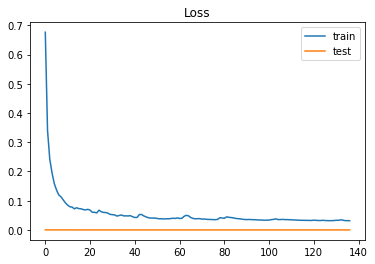

In [63]:
# Здесь необходимо отрисовать графики CrossEntropyLoss для обучающей и валидационной выборок

plt.title('Loss')

plt.plot(L_train, label='train')
plt.plot(L_test, label='test')
plt.legend()

In [64]:
# формируем сабмишшен и заливаем его на kaggle
make_submission(X_not_marked, net, fname="4layers136epochs.csv")